In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/hotspot_data"

Hotspots_Starter.ipynb		   vinny_adaboost_submission_7.csv
SampleSubmission.csv		   vinny_mlp_submission_4.csv
starter_submission.csv		   vinny_mlp_submission_5.csv
test.csv			   vinny_mlp_submission_6.csv
train.csv			   vinny_mlp_submission_8.csv
VariableDefinitionsHotspot.csv	   vinny_mlp_submission_9.csv
VariableDefinitionsHotspot.gsheet


In [0]:
!cp 'drive/My Drive/hotspot_data/train.csv' train.csv
!cp 'drive/My Drive/hotspot_data/test.csv' test.csv
!cp 'drive/My Drive/hotspot_data/VariableDefinitionsHotspot.csv' VariableDefinitionsHotspot.csv
!cp 'drive/My Drive/hotspot_data/SampleSubmission.csv' SampleSubmission.csv

In [6]:
#Load Dataset
path = "train.csv"
train = pd.read_csv(path, parse_dates=['date'])
train.shape
train.head()

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation
0,0_2000-04-01,0,2000-04-01,25.447,5.296,0.003688,1250.622712,0.0,-178.916305,1250.622712,158.387765,8.000000,498.913776,2143.430034,0.0,206.935453,323.873675,2508.795159,115.989282,129.825024,590.564102,0.0,0.0,0.350169,0.0,0.649524,0.0,0.000307,0.0,0.0,2.214262,0.198996
1,1_2000-04-01,1,2000-04-01,25.669,5.293,0.000000,1238.019166,0.0,-150.779947,1238.019166,164.645065,8.104576,590.346191,2132.253953,0.0,204.835170,321.838884,2500.432319,112.619789,129.471370,611.544277,0.0,0.0,0.429049,0.0,0.570644,0.0,0.000307,0.0,0.0,3.833042,0.188071
2,2_2000-04-01,2,2000-04-01,25.443,5.074,0.000000,1240.449964,0.0,-200.503858,1240.449964,163.699542,8.027851,536.613938,2139.632626,0.0,207.001206,321.846757,2519.259344,112.378707,127.550639,594.188987,0.0,0.0,0.238300,0.0,0.761700,0.0,0.000000,0.0,0.0,1.927303,0.211730
3,3_2000-04-01,3,2000-04-01,25.665,5.070,0.000000,1229.240077,0.0,-177.011032,1229.240077,172.996043,8.820002,648.271615,2125.206979,0.0,204.127473,319.348123,2493.392613,109.132390,131.703082,645.362481,0.0,0.0,0.488146,0.0,0.511854,0.0,0.000000,0.0,0.0,1.878281,0.215403
4,4_2000-04-01,4,2000-04-01,25.886,5.067,0.000307,1224.093679,0.0,-153.256111,1224.093679,178.396749,9.000000,719.423119,2114.709813,0.0,203.295123,318.639735,2487.984467,108.161469,133.354846,660.372381,0.0,0.0,0.322243,0.0,0.677757,0.0,0.000000,0.0,0.0,1.968818,0.199975


In [7]:
#Check for existing null values
train.isnull().sum() 

ID                        0
area                      0
date                      0
lat                       0
lon                       0
burn_area                 0
climate_aet               0
climate_def               0
climate_pdsi              0
climate_pet               0
climate_pr                0
climate_ro                0
climate_soil              0
climate_srad              0
climate_swe               0
climate_tmmn              0
climate_tmmx              0
climate_vap               0
climate_vpd               0
climate_vs                0
elevation                 0
landcover_0               0
landcover_1               0
landcover_2               0
landcover_3               0
landcover_4               0
landcover_5               0
landcover_6               0
landcover_7               0
landcover_8               0
population_density    19516
precipitation             0
dtype: int64

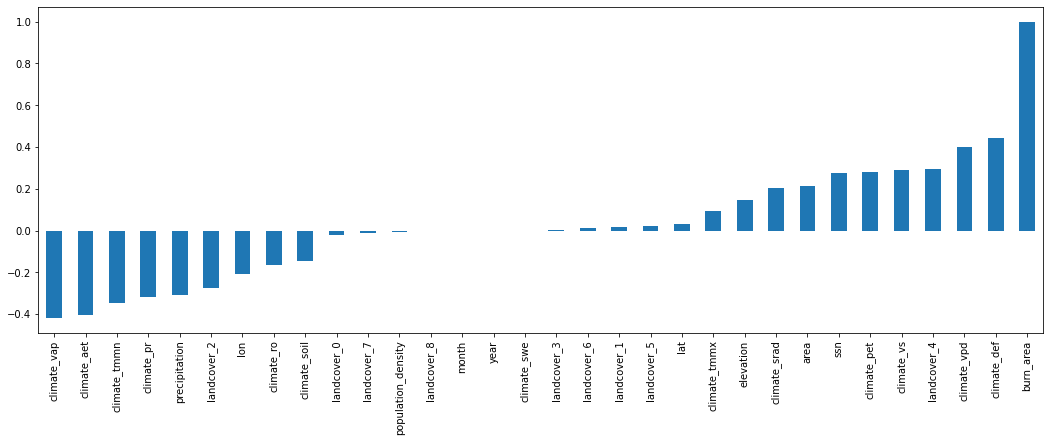

In [13]:
#view correlation of all the variables compared to the response variable(burn_area)
train.corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

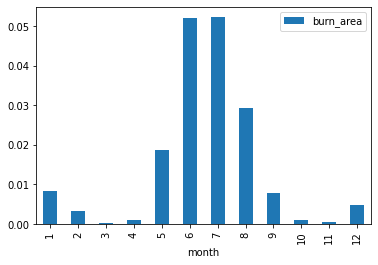

In [15]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

# Plotting mean burn_area for each month - very strong mid-year peak (dry season)
train.groupby('month').mean().reset_index().plot(y='burn_area', x='month', kind='bar')

In [8]:
#Create seasons 1-dry 0-wet
seasons = [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
month_to_season = dict(zip(range(1,13), seasons))
month_to_season 

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0}

In [0]:
#Add season variable to account for the seasonality in the data - Dry months get more burn area
train["ssn"]=train.date.dt.month.map(month_to_season) 

In [0]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

In [0]:
#Fill Nan values using median
train.fillna(train.median(), inplace=True)

In [0]:
#Drop columns
#This is an index column generated from other columns so we can drop it
train = train.drop(columns = ['climate_pdsi'])

(array([5.96036e+05, 1.45720e+04, 7.29300e+03, 3.97100e+03, 2.20700e+03,
        1.34800e+03, 7.57000e+02, 3.47000e+02, 9.00000e+01, 2.30000e+01]),
 array([0.        , 0.0952641 , 0.19052819, 0.28579229, 0.38105638,
        0.47632048, 0.57158457, 0.66684867, 0.76211276, 0.85737686,
        0.95264095]),
 <a list of 10 Patch objects>)

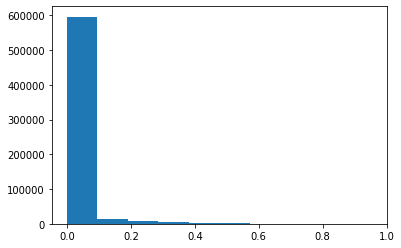

In [14]:
plt.hist((train.burn_area))

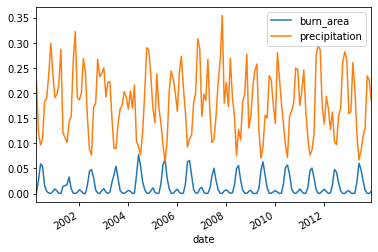

In [16]:
# Let's plot precipitation and burn area on the same plot - note the inverse relationship, and the strong periodic component to both.
ax = train.groupby('date').mean().reset_index().plot(y='burn_area', x='date')
train.groupby('date').mean().reset_index().plot(y='precipitation', x='date', ax=ax)

In [0]:
corr = train.corr()

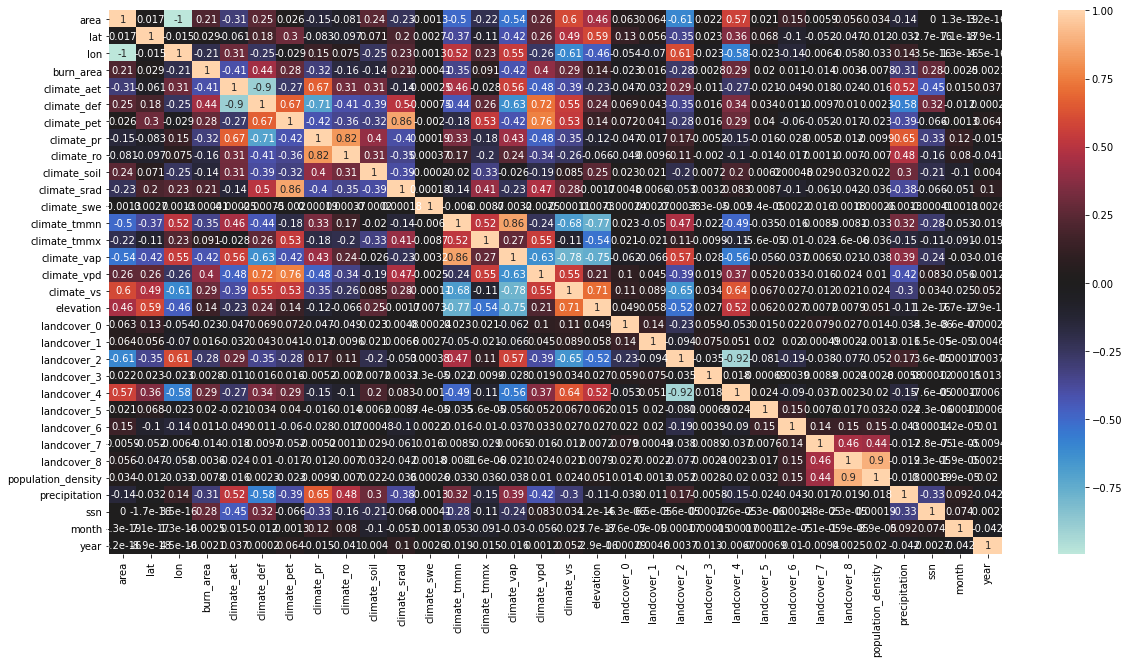

In [18]:
#Show correlation Matrix as a heatmap
plt.subplots(figsize=(20,10)) #Resize the heat map to fit all important information
sns.heatmap(corr, annot=True, center=0)

In [19]:
#Data Split for Validation
train_all = train.copy().dropna()
train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date > '2011-01-01']
print(train.shape, valid.shape)

(489088, 34) (133735, 34)


In [20]:
# Define input and output columns
in_cols = train.columns[6:]
target_col = 'burn_area'
in_cols


Index(['climate_aet', 'climate_def', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'population_density', 'precipitation', 'ssn', 'month',
       'year'],
      dtype='object')

In [0]:
# Get our X and y training and validation sets ready
X_train, y_train = train[in_cols], train[target_col]
X_valid, y_valid = valid[in_cols], valid[target_col]

In [22]:
#Create array of models to evaluate
'''
models = []
models.append(('LiR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('Bag_Re', BaggingRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Evaluations
results = []
names = []
scoring = []

for name, model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_train)
    
    # Evaluate the model
    score = mean_squared_error(y_valid, predictions)**0.5
    #mae = mean_absolute_error(predictions, Y)
    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    results.append(score)
    names.append(name)
    
    msg = "%s: %f " % (name, score)
    print(msg)
    '''

'\nmodels = []\nmodels.append((\'LiR\', LinearRegression()))\nmodels.append((\'Ridge\', Ridge()))\nmodels.append((\'Lasso\', Lasso()))\nmodels.append((\'ElasticNet\', ElasticNet()))\nmodels.append((\'Bag_Re\', BaggingRegressor()))\nmodels.append((\'RandomForest\', RandomForestRegressor()))\nmodels.append((\'ExtraTreesRegressor\', ExtraTreesRegressor()))\nmodels.append((\'KNN\', KNeighborsRegressor()))\nmodels.append((\'CART\', DecisionTreeRegressor()))\nmodels.append((\'SVM\', SVR()))\n\n# Evaluations\nresults = []\nnames = []\nscoring = []\n\nfor name, model in models:\n    # Fit the model\n    model.fit(X_train, y_train)\n    \n    predictions = model.predict(X_train)\n    \n    # Evaluate the model\n    score = mean_squared_error(y_valid, predictions)**0.5\n    #mae = mean_absolute_error(predictions, Y)\n    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))\n    results.append(score)\n    names.append(name)\n    \n    msg = "%s: %f " % (name, score)\n    print(msg)\n  

In [23]:
    #Select model
    '''
    model = ExtraTreesRegressor()
    # Fit the model
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_valid)
    
    # Evaluate the model
    score = mean_squared_error(y_valid, predictions)**0.5
    mae = mean_absolute_error(predictions, y_valid)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    results.append(mae)
    names.append(name)
    
    msg = "%s: %f " % (name, score)
   print(msg)
   '''

'\nmodel = ExtraTreesRegressor()\n# Fit the model\nmodel.fit(X_train, y_train)\n\npredictions = model.predict(X_valid)\n\n# Evaluate the model\nscore = mean_squared_error(y_valid, predictions)**0.5\nmae = mean_absolute_error(predictions, y_valid)\nprint("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))\nresults.append(mae)\nnames.append(name)\n\nmsg = "%s: %f " % (name, score)\n   print(msg)\n   '

In [24]:
#Select model
model = ExtraTreesRegressor()
#Fit the model
model.fit(train_all[in_cols], train_all[target_col])
#model.fit(train_all[in_cols],train_all[target_col])

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [25]:
# Look at the sample submission file
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,ID,Prediction
0,0_2014-01-01,0
1,1_2014-01-01,0
2,2_2014-01-01,0
3,3_2014-01-01,0
4,4_2014-01-01,0


In [26]:
# And the test data
test = pd.read_csv('test.csv',parse_dates=['date'])
test.head()

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation
0,0_2014-01-01,0,2014-01-01,25.447,5.296,0,142.756021,1217.926180,-953.401012,1360.571291,1.000000,0.0,355.593690,2349.499157,0.0,187.541787,332.578998,2542.124518,111.013969,156.563945,590.564102,0.0,0.0,0.430648,0.0,0.569045,0.0,0.000307,0.0,0.0,2.773423,0.000457
1,1_2014-01-01,1,2014-01-01,25.669,5.293,0,154.836847,1193.866315,-961.703043,1348.688788,1.000000,0.0,382.206636,2340.597389,0.0,185.895903,330.826066,2551.085649,106.576545,158.165429,611.544277,0.0,0.0,0.494624,0.0,0.505068,0.0,0.000307,0.0,0.0,4.697883,0.000129
2,2_2014-01-01,2,2014-01-01,25.443,5.074,0,127.790933,1223.640222,-962.435857,1351.521823,1.000000,0.0,318.078852,2351.867856,0.0,188.441645,330.077285,2551.183265,107.104292,153.257656,594.188987,0.0,0.0,0.288343,0.0,0.711657,0.0,0.000000,0.0,0.0,2.488614,0.000398
3,3_2014-01-01,3,2014-01-01,25.665,5.070,0,136.924571,1201.258784,-961.326298,1338.120278,1.000000,0.0,339.386497,2348.509414,0.0,185.393692,326.942319,2539.815326,101.962346,155.518048,645.362481,0.0,0.0,0.492103,0.0,0.507897,0.0,0.000000,0.0,0.0,2.439959,0.000158
4,4_2014-01-01,4,2014-01-01,25.886,5.067,0,144.278146,1197.831547,-959.248284,1342.118844,0.998555,0.0,358.043829,2341.881156,0.0,186.275015,327.839976,2549.462252,102.743046,159.865021,660.372381,0.0,0.0,0.333855,0.0,0.666145,0.0,0.000000,0.0,0.0,2.546723,0.000153


In [27]:
# So we need to predict the burn area for each row in test. 

# Add the same features to test as we did to train:
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test["ssn"]=test.date.dt.month.map(month_to_season)
#Drop unused columns
test = test.drop(columns = ['climate_pdsi'])

# Get predictions
preds = model.predict(test[in_cols].fillna(test.median())) # fillna(0) here could be improved by examining the missing data and filling more appropriately.

# Add to submission dataframe
ss['Prediction'] = preds

# View
ss.head()

,ID,Prediction
0,0_2014-01-01,0.194348
1,1_2014-01-01,0.169779
2,2_2014-01-01,0.260136
3,3_2014-01-01,0.230722
4,4_2014-01-01,0.298525


In [0]:
# Save ready for submission:
ss.to_csv('IML_ExtraTreesRegressor_median_ssns_droppedfs3.csv', index=False)